In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import re
import math
import json
import nltk
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [2]:
queries_json = json.load(open("cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json],[item["query"] for item in queries_json]

In [3]:
docs_json = json.load(open("cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json],[item["body"] for item in docs_json]

In [4]:
qrels = json.load(open("cran_qrels.json", 'r'))[:]

In [5]:
tokenize = RegexpTokenizer(r'\b\w{1,}\b')
stop_words = set(stopwords.words("english"))

In [6]:
class LemmaTokenizer(object):
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`', '(', ')', '+', '-', '--', '*', '/', '', 'viz']
    def __init__(self):
        #self.wnl = WordNetLemmatizer()
        self.wnl = PorterStemmer()
    def __call__(self, articles):
        return [self.wnl.stem(re.sub(r'[0-9]', "", t)) for t in tokenize.tokenize(articles) if re.sub(r'[0-9]', "", t) not in self.ignore_tokens]

In [7]:
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

In [8]:
sample_tfidf = TfidfVectorizer(lowercase = True, stop_words = token_stop, tokenizer = tokenizer) #, min_df = 0.1)
sample_sparse = sample_tfidf.fit_transform(docs)
tfidf = sample_sparse.toarray()

c:\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [9]:
tfidf.shape

(1400, 4295)

In [10]:
len(sample_tfidf.get_feature_names())

4295

In [11]:
u, s, vh = np.linalg.svd(np.transpose(tfidf), full_matrices = False)

In [12]:
sample_sparse_q = sample_tfidf.transform(queries)
tfidf_q = sample_sparse_q.toarray()

In [13]:
tfidf_q.shape

(225, 4295)

In [14]:
def LSI(n_components, u, s, vh, tfidf_q):
    T = u[:,:n_components]
    S = np.diag(s[:n_components])
    Dt = vh[:n_components,:]
    doc_vectors = np.dot(np.transpose(Dt), S)
    query_vectors = np.dot(tfidf_q, T)
    return doc_vectors, query_vectors

In [15]:
def rank(doc_vectors, query_vectors, docIDs):
    doc_IDs_ordered = list()
    for q_vector in query_vectors:
        retrieved_docs = dict()
        key = 0
        for doc_vector in doc_vectors:
            cosine = 1 - distance.cosine(doc_vector, q_vector)
            retrieved_docs[docIDs[key]] = cosine
            key += 1
        doc_IDs_ordered.append(sorted(retrieved_docs,reverse=True,key = lambda x: retrieved_docs[x]))
    return doc_IDs_ordered

In [16]:
class Evaluation():

	def queryPrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
		"""
		Computation of precision of the Information Retrieval System
		at a given value of k for a single query

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			The list of IDs of documents relevant to the query (ground truth)
		arg4 : int
			The k value

		Returns
		-------
		float
			The precision value as a number between 0 and 1
		"""

		precision = -1
		retrieved_docs = query_doc_IDs_ordered[:k]
		n_relevant_docs = 0
		
		for doc in retrieved_docs:
			if doc in true_doc_IDs:
				n_relevant_docs+=1
		
		precision = n_relevant_docs/k

		return precision


	def meanPrecision(self, doc_IDs_ordered, query_ids, qrels, k):
		"""
		Computation of precision of the Information Retrieval System
		at a given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries for which the documents are ordered
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value

		Returns
		-------
		float
			The mean precision value as a number between 0 and 1
		"""

		meanPrecision = -1
		total_Precision = 0
		count = 0
		for i in query_ids:
			true_doc_IDs = []
			flag = 0
			for dic in qrels:
				if(int(dic["query_num"]) == i):
					flag = 1
					true_doc_IDs.append(int(dic["id"]))
				elif(flag == 1):
					break     
			total_Precision = total_Precision + self.queryPrecision(doc_IDs_ordered[count] , i , true_doc_IDs, k)
			count = count+1
		if count == 0:
	  		count = 1
		meanPrecision = total_Precision/count

		return meanPrecision

	
	def queryRecall(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
		"""
		Computation of recall of the Information Retrieval System
		at a given value of k for a single query

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			The list of IDs of documents relevant to the query (ground truth)
		arg4 : int
			The k value

		Returns
		-------
		float
			The recall value as a number between 0 and 1
		"""

		recall = -1
		retrieved_docs = query_doc_IDs_ordered[:k]
		n_relevant_docs = 0
		for doc in retrieved_docs:
			if doc in  true_doc_IDs:
				n_relevant_docs += 1
		recall = n_relevant_docs/len(true_doc_IDs)

		return recall


	def meanRecall(self, doc_IDs_ordered, query_ids, qrels, k):
		"""
		Computation of recall of the Information Retrieval System
		at a given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries for which the documents are ordered
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value

		Returns
		-------
		float
			The mean recall value as a number between 0 and 1
		"""

		meanRecall = -1
		total_Recall = 0
		count = 0
		for i in query_ids:
			true_doc_IDs = []
			flag = 0
			for dic in qrels:
				if(int(dic["query_num"]) == i):
					flag = 1
					true_doc_IDs.append(int(dic["id"]))
				elif(flag == 1):
					break
			total_Recall = total_Recall + self.queryRecall(doc_IDs_ordered[count] , i , true_doc_IDs, k)
			count = count+1
		if count == 0:
	  		count = 1
		meanRecall = total_Recall/count

		return meanRecall


	def queryFscore(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
		"""
		Computation of fscore of the Information Retrieval System
		at a given value of k for a single query

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			The list of IDs of documents relevant to the query (ground truth)
		arg4 : int
			The k value

		Returns
		-------
		float
			The fscore value as a number between 0 and 1
		"""

		fscore = -1
		precision = self.queryPrecision(query_doc_IDs_ordered , query_id , true_doc_IDs, k)
		recall = self.queryRecall(query_doc_IDs_ordered , query_id , true_doc_IDs, k)
		fscore = (2*precision*recall)/(precision + recall + 0.00001)

		return fscore


	def meanFscore(self, doc_IDs_ordered, query_ids, qrels, k):
		"""
		Computation of fscore of the Information Retrieval System
		at a given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries for which the documents are ordered
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value
		
		Returns
		-------
		float
			The mean fscore value as a number between 0 and 1
		"""

		meanFscore = -1
		total_Fscore = 0
		count = 0
		for i in query_ids:
			true_doc_IDs = []
			flag = 0
			for dic in qrels:
				if(int(dic["query_num"]) == i):
					flag = 1
					true_doc_IDs.append(int(dic["id"]))
				elif(flag == 1):
					break
			total_Fscore = total_Fscore + self.queryFscore(doc_IDs_ordered[count] , i , true_doc_IDs, k)
			count = count+1
		if count == 0:
	  		count = 1
		meanFscore = total_Fscore/count

		return meanFscore
	

	def queryNDCG(self, query_doc_IDs_ordered, query_id, qrels, k):
		"""
		Computation of nDCG of the Information Retrieval System
		at given value of k for a single query

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value

		Returns
		-------
		float
			The nDCG value as a number between 0 and 1
		"""

		nDCG = -1
		DCG = 0
		iDCG = 0
		retrieved_docs = query_doc_IDs_ordered[:k]
		true_doc_IDs = dict()
		flag = 0
		
		for dic in qrels:
			if(int(dic["query_num"]) == query_id):
				flag = 1
				true_doc_IDs[int(dic["id"])] = 5 - dic['position']
			elif(flag == 1):
				break
		ideal_order = sorted(query_doc_IDs_ordered, key = lambda x: true_doc_IDs[x] if x in true_doc_IDs else 0, reverse = True)[:k]
		for i in range(1,k+1):
			if retrieved_docs[i-1] in true_doc_IDs:
				DCG += true_doc_IDs[retrieved_docs[i-1]]/math.log2(i+1)
			if ideal_order[i-1] in true_doc_IDs:
				iDCG += true_doc_IDs[ideal_order[i-1]]/math.log2(i+1)

		if iDCG == 0:
			iDCG = 1	
		nDCG = DCG/iDCG

		return nDCG


	def meanNDCG(self, doc_IDs_ordered, query_ids, qrels, k):
		"""
		Computation of nDCG of the Information Retrieval System
		at a given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries for which the documents are ordered
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value

		Returns
		-------
		float
			The mean nDCG value as a number between 0 and 1
		"""

		meanNDCG = -1
		total_NDCG = 0
		count = 0
		for i in query_ids:
			total_NDCG = total_NDCG + self.queryNDCG(doc_IDs_ordered[count] , i , qrels, k)
			count = count+1
		if count == 0:
	  		meanNDCG = 0
		else:
			meanNDCG = total_NDCG/count

		return meanNDCG


	def queryAveragePrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
		"""
		Computation of average precision of the Information Retrieval System
		at a given value of k for a single query (the average of precision@i
		values for i such that the ith document is truly relevant)

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			The list of documents relevant to the query (ground truth)
		arg4 : int
			The k value

		Returns
		-------
		float
			The average precision value as a number between 0 and 1
		"""

		avgPrecision = -1
		retrieved_docs = query_doc_IDs_ordered[:k]
		Total_Precision = 0
		count = 0
		for i in range(len(retrieved_docs)):
			doc = retrieved_docs[i]
			if doc in true_doc_IDs:
				count += 1
				Total_Precision += self.queryPrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, i+1) 
		if count == 0:
			avgPrecision = 0
		else:      
			avgPrecision = Total_Precision/count

		return avgPrecision


	def meanAveragePrecision(self, doc_IDs_ordered, query_ids, qrels, k):
		"""
		Computation of MAP of the Information Retrieval System
		at given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value

		Returns
		-------
		float
			The MAP value as a number between 0 and 1
		"""

		meanAveragePrecision = -1
		total_AveragePrecision = 0
		count = 0
		for i in query_ids:
			true_doc_IDs = []
			flag = 0
			for dic in qrels:
				if(int(dic["query_num"]) == i):
					flag = 1
					true_doc_IDs.append(int(dic["id"]))
				elif(flag == 1):
					break
			total_AveragePrecision = total_AveragePrecision + self.queryAveragePrecision(doc_IDs_ordered[count] , i , true_doc_IDs, k)
			count = count+1
		if count == 0:
	  		count = 1
		meanAveragePrecision = total_AveragePrecision/count

		return meanAveragePrecision

In [17]:
evaluator = Evaluation()

In [18]:
nDCG_n = list()
for n in range(100, 1100, 100):
    d_vectors, q_vectors = LSI(n, u, s, vh, tfidf_q)
    d_IDs_ordered = rank(d_vectors, q_vectors, doc_ids)
    nDCG_n.append(evaluator.meanNDCG(d_IDs_ordered, query_ids, qrels, 10))

c:\python37\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


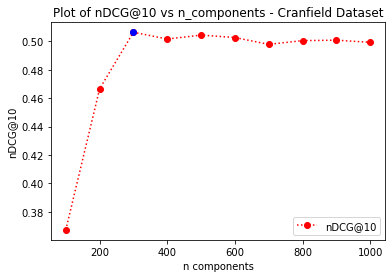

In [19]:
# Plot the metrics 
plt.plot(range(100, 1100, 100), nDCG_n, 'o:r', label="nDCG@10")
plt.plot([300], [max(nDCG_n)], 'o:b')
plt.legend()
plt.title("Plot of nDCG@10 vs n_components - Cranfield Dataset")
plt.xlabel("n components")
plt.ylabel("nDCG@10")
plt.savefig('a.png')

In [20]:
nDCG_n

[0.3672322957537652,
 0.46658564159568855,
 0.5064317197374757,
 0.5016583880180165,
 0.5044120257205383,
 0.5027097967231616,
 0.49789487106710983,
 0.5005244010159443,
 0.5008371053523702,
 0.49934049776641665]

In [18]:
n_components = 300 # Parameter to tune
doc_vectors, query_vectors = LSI(n_components, u, s, vh, tfidf_q)
doc_IDs_ordered_LSI = rank(doc_vectors, query_vectors, doc_ids)
doc_IDs_ordered_VSM = rank(tfidf, tfidf_q, doc_ids)

c:\python37\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [19]:
# Calculate precision, recall, f-score, MAP and nDCG for k = 1 to 10
precisions, recalls, fscores, nDCGs_LSI, nDCGs_VSM = [], [], [], [], []
for i in range(225):
    '''precision = evaluator.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
    precisions.append(precision)
    recall = evaluator.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
    recalls.append(recall)
    fscore = evaluator.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
    fscores.append(fscore)
    print("Precision, Recall and F-score @ " +  str(k) + " : " + str(precision) + ", " + str(recall) + ", " + str(fscore))
    MAP = evaluator.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
    MAPs.append(MAP)'''
    nDCG_LSI = evaluator.queryNDCG(doc_IDs_ordered_LSI[i], query_ids[i], qrels, 10)
    nDCGs_LSI.append(nDCG_LSI)
    nDCG_VSM = evaluator.queryNDCG(doc_IDs_ordered_VSM[i], query_ids[i], qrels, 10)
    nDCGs_VSM.append(nDCG_VSM)
    #print("MAP, nDCG @ " +  str(k) + " : " + str(MAP) + ", " + str(nDCG))

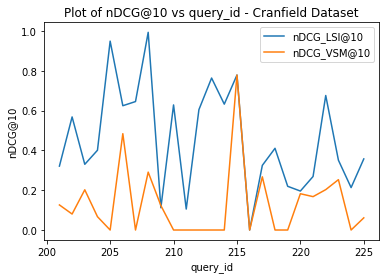

In [24]:
# Plot the metrics 
#plt.plot(range(1, 11), precisions, label="Precision")
#plt.plot(range(1, 11), recalls, label="Recall")
#plt.plot(range(1, 11), fscores, label="F-Score")
plt.plot(range(201,226), nDCGs_LSI[200:225], label="nDCG_LSI@10")
plt.plot(range(201,226), nDCGs_VSM[200:225], label="nDCG_VSM@10")
plt.legend()
plt.title("Plot of nDCG@10 vs query_id - Cranfield Dataset")
plt.xlabel("query_id")
plt.ylabel("nDCG@10")
plt.savefig('g.png')

In [21]:
nDCGs[-1]

0.48350818633272336

In [33]:
pca = PCA(n_components = 2)
doc_vectors_transform = pca.fit_transform(doc_vectors)

In [34]:
pca.explained_variance_ratio_

array([0.02921099, 0.02561569])

In [35]:
# Helper function to plot the data as clusters 

def plot3clusters(X, title, vtitle, target_names):
    plt.figure()
    
    # Select the colours of the clusters
    colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080'] 
    lw = 2
    plt.figure(figsize=(9,7));
    for color, i, target_name in zip(colors, list(range(20)), target_names):
        plt.scatter(X[i, 0], X[i, 1], color=color, alpha=1., lw=lw, label=target_name);
   
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title);
    plt.xlabel(vtitle + "1")
    plt.ylabel(vtitle + "2")
    plt.show();

<Figure size 432x288 with 0 Axes>

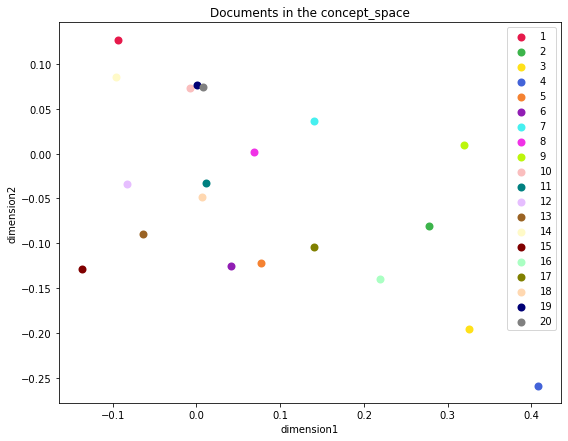

In [36]:
plot3clusters(doc_vectors_transform, 'Documents in the concept_space', 'dimension', doc_ids[:20])

In [37]:
pca = PCA(n_components = 3)
doc_vectors_transform = pca.fit_transform(doc_vectors)

In [38]:
pca.explained_variance_ratio_

array([0.02921099, 0.0256157 , 0.01863581])

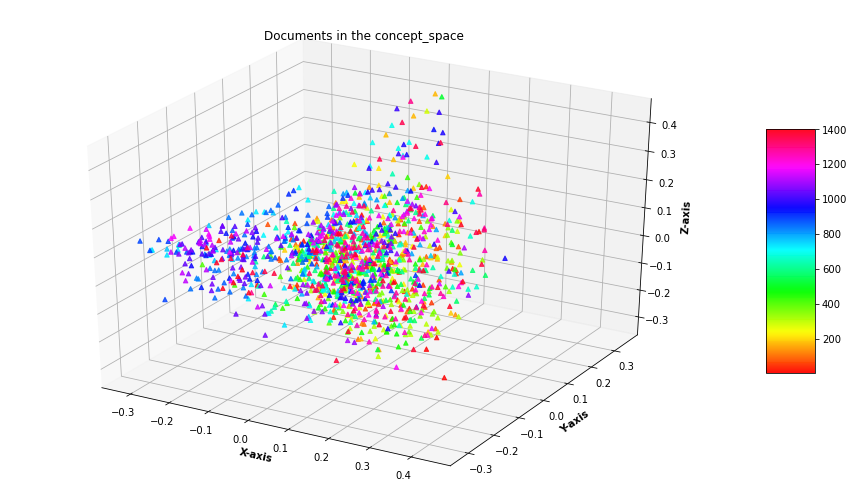

In [39]:
x = doc_vectors_transform[:,0]
y = doc_vectors_transform[:,1]
z = doc_vectors_transform[:,2]

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = doc_ids,
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Documents in the concept_space")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

In [199]:
cosine = 1 - distance.cosine(doc_vectors[11], doc_vectors[12])
cosine

0.03247534214095327

In [200]:
docs[11]

'some structural and aerelastic considerations of high speed flight .   the dominating factors in structural design of high-speed aircraft are thermal and aeroelastic in origin .  the subject matter is concerned largely with a discussion of these factors and their interrelation with one another .  a summary is presented of some of the analytical and experimental tools available to aeronautical engineers to meet the demands of high-speed flight upon aircraft structures .  the state of the art with respect to heat transfer from the boundary layer into the structure, modes of failure under combined load as well as thermal inputs and acrothermoelasticity is discussed .  methods of attacking and alleviating structural and aeroelastic problems of high-speed flight are summarized .  finally, some avenues of fundamental research are suggested .'

In [201]:
docs[12]

'similarity laws for stressing heated wings .   it will be shown that the differential equations for a heated plate with large temperature gradient and for a similar plate at constant temperature can be made the same by a proper modification of the thickness and the loading for the isothermal plate . this fact leads to the result that the stresses in the heated plate can be calculated from measured strains on the unheated plate by a series of relations, called the /similarity laws ./  the application of this analog theory to solid wings under aerodynamic heating is discussed in detail .  the loading on the unheated analog wing is, however, complicated and involves the novel concept of feedback and /body force/ loading .  the problem of stressing a heated box-wing structure can be solved by the same analog method and is briefly discussed .'

In [38]:
for i in qrels:
    if i['id'] == '2':
        print(i['query_num'],i['position'])

65 2
67 1


In [49]:
queries[14]

'material properties of photoelastic materials .'

In [48]:
for i in qrels:
    if i['query_num'] == '15':
        print(i['id'],i['position'])

463 1
462 3
497 1


In [157]:
doc_vectors.shape

(1400, 300)

In [14]:
tokenize.tokenize("haven't")

['haven', 't']

In [12]:
queries[50]

'what is the available information pertaining to boundary layers on very slender bodies of revolution in continuum flow (the ?transverse curvature  effect) .'